In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import numpy as np
import glob
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
X_data = []
Y_data = []

path = "/content/drive/MyDrive/NNDL/HW6/Dataset/Class "
for i in range(5):
  files = glob.glob(path + str(i+1) + "/*.png")
  for myFile in files:
    image = cv2.imread(myFile,0)
    res = cv2.resize(image, dsize=(28, 28))
    # image = cv2.IMREAD_GRAYSCALE (myFile)
    X_data.append (res)
    Y_data.append (i+1)

X_data = np.array(X_data)
Y_data = np.array(Y_data)
print('X_data shape:', X_data.shape)
print('Y_data shape:', Y_data.shape)

X_data shape: (1005, 28, 28)
Y_data shape: (1005,)


In [ ]:
X_data.shape, Y_data.shape, type(X_data), type(Y_data)

((1005, 28, 28), (1005,), numpy.ndarray, numpy.ndarray)

class: 1


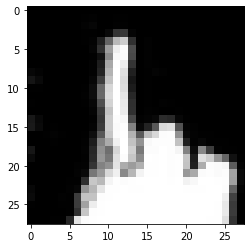

In [ ]:
plt.imshow(X_data[1],cmap='gray')
print('class:',Y_data[1])

class: 5


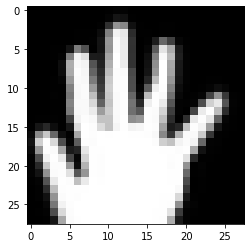

In [ ]:
plt.imshow(X_data[901],cmap='gray')
print('class:',Y_data[901])

shuffle the data

In [ ]:
np.random.seed(5)  
np.random.shuffle(Y_data)  
np.random.seed(5) 
np.random.shuffle(X_data)  

class: 2


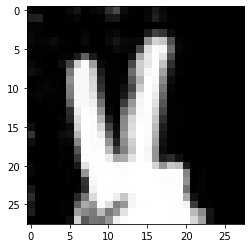

In [ ]:
plt.imshow(X_data[2],cmap='gray')
print('class:',Y_data[2])

# ACGAN

In [ ]:
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import os
os.mkdir('/content/images')

In [2]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, LeakyReLU
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
# from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt

import numpy as np

class ACGAN():
    def __init__(self, input_rows, input_cols, input_channels, input_classes, latent_dim=100):
        self.img_rows = input_rows
        self.img_cols = input_cols
        self.channels = input_channels
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.num_classes = input_classes
        self.latent_dim = latent_dim

        optimizer = Adam(0.0002, 0.5)
        losses = ['binary_crossentropy', 'sparse_categorical_crossentropy']

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss=losses,
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,))
        img = self.generator([noise, label])

        self.discriminator.trainable = False

        valid, target_label = self.discriminator(img)

        self.combined = Model([noise, label], [valid, target_label])
        self.combined.compile(loss=losses,
            optimizer=optimizer)

    def build_generator(self):

        model = Sequential()

        model.add(Dense(128 * 7 * 7, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((7, 7, 128)))
        model.add(BatchNormalization(momentum=0.8))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(self.channels, kernel_size=3, padding='same'))
        model.add(Activation("tanh"))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,), dtype='int32')
        label_embedding = Flatten()(Embedding(self.num_classes, 100)(label))

        model_input = multiply([noise, label_embedding])
        img = model(model_input)

        return Model([noise, label], img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Conv2D(16, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(32, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(128, kernel_size=3, strides=1, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))

        model.add(Flatten())
        model.summary()

        img = Input(shape=self.img_shape)

        features = model(img)
        validity = Dense(1, activation="sigmoid")(features)
        label = Dense(self.num_classes+1, activation="softmax")(features)

        return Model(img, [validity, label])

    def train(self, X_train, y_train, epochs, batch_size=128, sample_interval=50):

        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        X_train = np.expand_dims(X_train, axis=3)
        y_train = y_train.reshape(-1, 1)

        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        g_loss_epochs = np.zeros((epochs, 1))
        d_loss_epochs = np.zeros((epochs, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (batch_size, 100))

            sampled_labels = np.random.randint(0, 5, (batch_size, 1))

            gen_imgs = self.generator.predict([noise, sampled_labels])

            img_labels = y_train[idx]
            fake_labels = 5 * np.ones(img_labels.shape)

            d_loss_real = self.discriminator.train_on_batch(imgs, [valid, img_labels])
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, [fake, fake_labels])
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            g_loss = self.combined.train_on_batch([noise, sampled_labels], [valid, sampled_labels])

            g_loss_epochs[epoch] = g_loss[0]
            d_loss_epochs[epoch] = d_loss[0]

            if epoch % sample_interval == 0:
                print ("Epoch: %d [D loss: %f, acc.: %.2f%%, op_acc: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[3], 100*d_loss[4], g_loss[0]))
                self.sample_images(epoch, smp_rows=2, smp_cols=5, save_img=True)

        return g_loss_epochs, d_loss_epochs
 

    def sample_images(self, epoch, smp_rows=5, smp_cols=5, save_img=True, fig_size=(8, 3)):
        r, c = smp_rows, smp_cols
        noise = np.random.normal(0, 1, (r * c, 100))
        sampled_labels = np.array([num for _ in range(r) for num in range(c)])
        gen_imgs = self.generator.predict([noise, sampled_labels])
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c, figsize=fig_size)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt,:,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        if save_img:
            fig.savefig("/content/images/%d.png" % epoch)
            plt.show()
        else:
            plt.show()
        plt.close()

    def save_model(self):

        def save(model, model_name):
            model_path = "../saved_model/%s.json" % model_name
            weights_path = "../saved_model/%s_weights.hdf5" % model_name
            options = {"file_arch": model_path,
                        "file_weight": weights_path}
            json_string = model.to_json()
            #
            open(options['file_arch'], 'w').write(json_string)
            model.save_weights(options['file_weight'])

        save(self.generator, "generator")
        save(self.discriminator, "discriminator")

In [3]:
#label dictionary
label_dict = {0: 'one',
              1: 'two',
              2: 'three',
              3: 'four',
              4: 'five'}

In [4]:
#input dimensions
input_rows = 28
input_cols = 28
input_channels = 1
input_classes = 5

In [ ]:
X_train = X_data
y_train = Y_data - 1

In [ ]:
X_train.shape, y_train.shape, type(X_train), type(y_train)

((1005, 28, 28), (1005,), numpy.ndarray, numpy.ndarray)

In [7]:
q2_acgan = ACGAN(input_rows, input_cols, input_channels, input_classes)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 16)        160       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 16)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 32)          4640      
                                                                 
 zero_padding2d (ZeroPadding  (None, 8, 8, 32)         0         
 2D)                                                             
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 8, 8, 32)          0         
                                                        

1/1 [==============================] - 0s 100ms/step


Epoch: 0 [D loss: 2.827604, acc.: 31.25%, op_acc: 18.75%] [G loss: 2.503042]
1/1 [==============================] - 0s 94ms/step


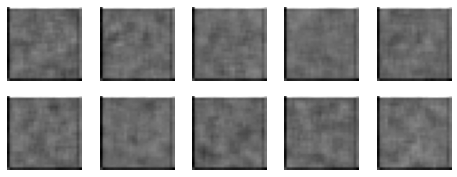

1/1 [==============================] - 0s 14ms/step
Epoch: 200 [D loss: 0.902369, acc.: 75.00%, op_acc: 81.25%] [G loss: 4.082399]
1/1 [==============================] - 0s 15ms/step


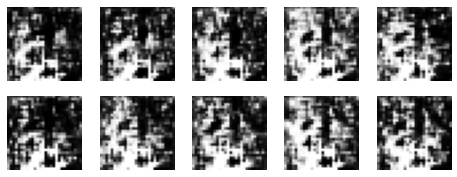

1/1 [==============================] - 0s 16ms/step
Epoch: 400 [D loss: 1.513123, acc.: 50.00%, op_acc: 68.75%] [G loss: 3.871200]
1/1 [==============================] - 0s 15ms/step


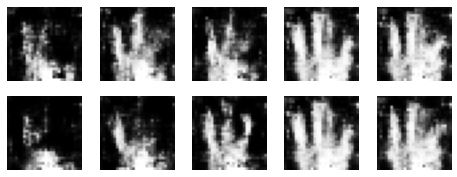

1/1 [==============================] - 0s 15ms/step
Epoch: 600 [D loss: 0.517254, acc.: 87.50%, op_acc: 81.25%] [G loss: 1.654642]
1/1 [==============================] - 0s 24ms/step


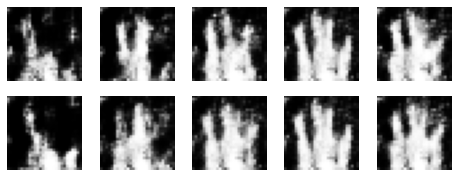

1/1 [==============================] - 0s 17ms/step
Epoch: 800 [D loss: 0.682731, acc.: 81.25%, op_acc: 87.50%] [G loss: 2.042773]
1/1 [==============================] - 0s 20ms/step


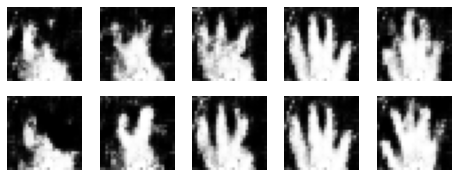

1/1 [==============================] - 0s 14ms/step
Epoch: 1000 [D loss: 0.489874, acc.: 93.75%, op_acc: 93.75%] [G loss: 1.790379]
1/1 [==============================] - 0s 16ms/step


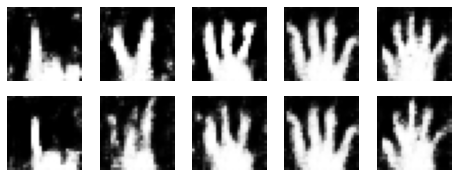

1/1 [==============================] - 0s 16ms/step
Epoch: 1200 [D loss: 1.001794, acc.: 75.00%, op_acc: 81.25%] [G loss: 1.310548]
1/1 [==============================] - 0s 18ms/step


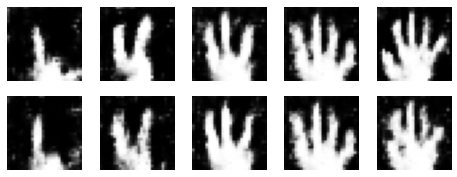

1/1 [==============================] - 0s 16ms/step
Epoch: 1400 [D loss: 0.629504, acc.: 93.75%, op_acc: 81.25%] [G loss: 1.794115]
1/1 [==============================] - 0s 17ms/step


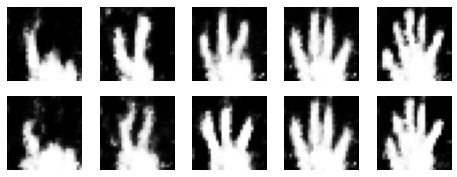

1/1 [==============================] - 0s 16ms/step
Epoch: 1600 [D loss: 2.040880, acc.: 50.00%, op_acc: 68.75%] [G loss: 1.268580]
1/1 [==============================] - 0s 14ms/step


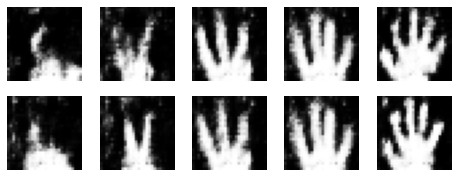

1/1 [==============================] - 0s 22ms/step
Epoch: 1800 [D loss: 0.420728, acc.: 100.00%, op_acc: 87.50%] [G loss: 0.576194]
1/1 [==============================] - 0s 17ms/step


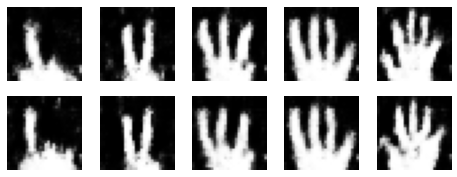

1/1 [==============================] - 0s 16ms/step
Epoch: 2000 [D loss: 0.513501, acc.: 93.75%, op_acc: 81.25%] [G loss: 1.018010]
1/1 [==============================] - 0s 16ms/step


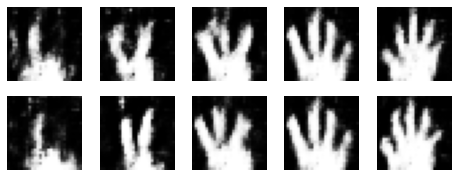

In [ ]:
#Train the AC-GAN with the data
g_loss, d_loss = q2_acgan.train(X_train, y_train, epochs=2001, batch_size=8, sample_interval=200)

In [ ]:
def plot_gan_losses(g_loss, d_loss):
    plt.plot(g_loss)
    plt.plot(d_loss)
    plt.title('GAN Loss evolution')
    plt.ylabel('')
    plt.xlabel('epoch')
    plt.legend(['Generator', 'Discriminator'], loc='upper left')
    plt.show()

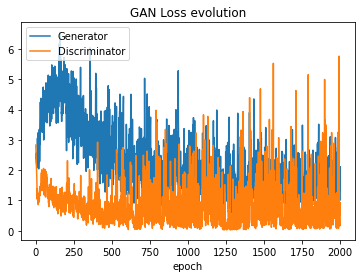

In [ ]:
plot_gan_losses(g_loss, d_loss)